# Yelp Data Text Analysis and Modeling

This notebook demonstrates a complete pipeline for exploring, preprocessing, and modeling a subset of the Yelp dataset. The main objective is to predict whether a Yelp review is “more useful” or “less useful” based on both text and numeric features. We employ multiple classification techniques, including:

- Traditional machine learning models (Logistic Regression, Random Forest, etc.)
- Imbalanced-learning approaches (Cost-sensitive learning)
- Ensemble methods (AdaBoost, Stacking)
- Deep Learning architectures (BERT, LSTM, Multi-Input Models)

This notebook contains the following steps:

1. **Data Loading & Preprocessing**
2. **Exploratory Data Analysis (EDA)**
3. **Feature Engineering** (Numeric, Text, & Dimensionality Reduction)
4. **Model Training & Evaluation** (with cross-validation, metrics, and interpretability)
5. **Advanced Methods** (Imbalanced classification, ensembles, and deep learning approaches)

### Setup and Global Imports

In [1]:
import os
import sys
import numpy as np
import pandas as pd

utils_path = os.path.join(os.getcwd(), "utils")
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Import utility modules (preprocessing, plotting, modeling, etc.)
from preprocessing import (
    load_and_clean_data, transform_numeric_features, impute_binary_columns,
    TextTransformer, transform_text_features
)
from plotting import (
    plot_numeric_histograms, plot_categorical_bars, plot_target_distribution
)
from modeling import create_preprocessor
from ensemble import adacost_train, adacost_predict
from deep_learning import finetune_bert, build_lstm_model, build_multi_input_model
from evaluation import comprehensive_evaluation

# Additional libraries for modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import ADASYN

# Ensure tokenizer parallelism is disabled (for transformers)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## 1. Data Loading and Initial Cleaning

We begin by loading multiple raw Yelp JSON files (`review`, `user`, and `business`) into a **SQLite** database. This approach lets us select only relevant columns and neatly join the three tables, which contain review text, user attributes (e.g., fans, average_stars), and business details (e.g., parking/ambience attributes).

Next, we **expand** dictionary-like fields (e.g., `BusinessParking`, `Ambience`) into separate boolean columns and merge **ZIP code income data** from a Kaggle dataset. This step creates a richer feature space (e.g., a numeric `parking_count` and `region_income`). We also **filter** out average or low-usefulness reviews, retaining only “less useful” (< 40th percentile) and “more useful” (> 60th percentile) ones for clearer labeling.

Finally, the pipeline **consolidates** all information into a single CSV (`yelp_reduced.csv`). The `load_and_clean_data` function in `preprocessing.py` then removes columns irrelevant for modeling (IDs, etc.) and converts binary fields (like price range) to numeric codes, leaving a streamlined dataset ready for analysis.

In [2]:
file_path = os.path.join("yelp_dataset", "yelp_reduced.csv")
df = load_and_clean_data(file_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117807 entries, 0 to 1117806
Data columns (total 14 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   business_review_count   1117807 non-null  int64  
 1   text                    1117807 non-null  object 
 2   average_stars           1117807 non-null  float64
 3   stars                   1117807 non-null  float64
 4   business_stars          1117807 non-null  float64
 5   user_review_count       1117807 non-null  float64
 6   fans                    1117807 non-null  float64
 7   useful_category         1117807 non-null  object 
 8   user_total_votes        1117807 non-null  float64
 9   user_total_compliments  1117807 non-null  float64
 10  parking_count           1117807 non-null  int64  
 11  region_income           1117807 non-null  float64
 12  price_binary            859135 non-null   float64
 13  attire_binary           578265 non-null   float64
dtypes:

From the output:
- The dataset includes numeric and object (text, useful_category) columns.
- Columns like `price_binary` and `attire_binary` have missing values.

## 2. Splitting Data into Features and Target

- We are predicting whether each Yelp review is “less useful” or “more useful,” stored in the `useful_category` column.
- We use a standard 80/20 train-test split with `stratify=y` to preserve class distribution in both sets.

In [3]:
X = df.drop(columns=['useful_category'])
y = df['useful_category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 3. Imputation for Binary Columns

We impute missing values in the `price_binary` and `attire_binary` columns using a KNN classifier. For each binary column, the KNN model is trained on rows where the column is known, using the other numeric features (excluding the text column) as predictors. Note that the KNN model is fit and validated on the train sets only. We then fill in the missing rows for both training and test sets with the KNN’s predictions. This approach leverages local similarity among rows to provide more data-driven imputation than a simple mean or mode fill, helping preserve valuable samples for downstream modeling.

In [4]:
binary_cols = ['price_binary', 'attire_binary']
X_train, X_test = impute_binary_columns(X_train, X_test, binary_cols)


Imputing missing values for: price_binary
CV scores for price_binary: [0.91170542 0.91167631 0.9110723  0.91228032 0.91024932]
Mean CV accuracy for price_binary: 0.9114
Remaining missing values in train for price_binary: 0
Remaining missing values in test for price_binary: 0

Imputing missing values for: attire_binary
CV scores for attire_binary: [0.96562422 0.96612148 0.96495362 0.965786   0.9654617 ]
Mean CV accuracy for attire_binary: 0.9656
Remaining missing values in train for attire_binary: 0
Remaining missing values in test for attire_binary: 0


Outputs above shows cross-validation accuracies (90%+) for each binary column predictor and confirms no more missing values.

## 4. Exploratory Data Analysis (EDA)

- We look at **numerical features** (e.g., `business_review_count`, `average_stars`, etc.) to see if they are skewed or if there are outliers. If skewness is present, in the preprocessing we transform the skewed features.
- We look at **categorical features** (e.g., `stars`, `parking_count`, `price_binary`) to understand their frequency distribution.
- Finally, we look at our **target variable** distribution to check for imbalance—this can inform whether we need strategies like cost-sensitive learning or oversampling, or use models insensitive to class imbalance.

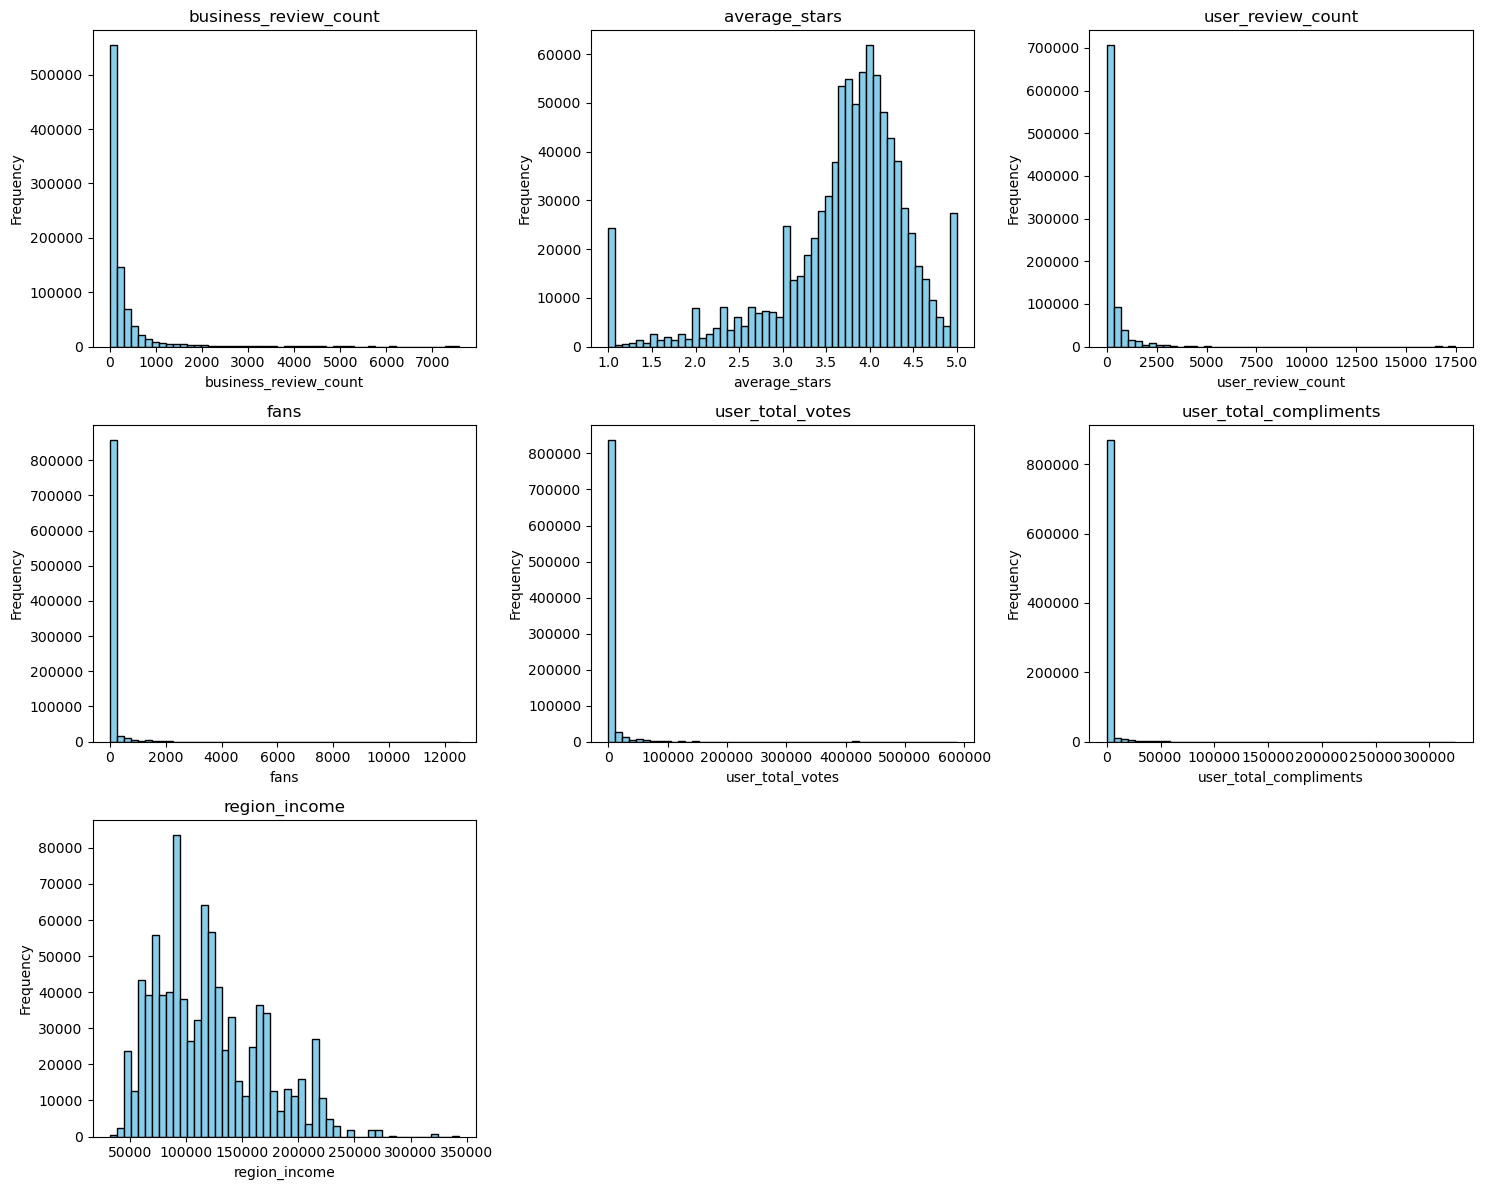

In [5]:
# Numeric Features Histogram
num_cols = ['business_review_count', 'average_stars', 'user_review_count',
            'fans', 'user_total_votes', 'user_total_compliments', 'region_income']
plot_numeric_histograms(X_train, num_cols)

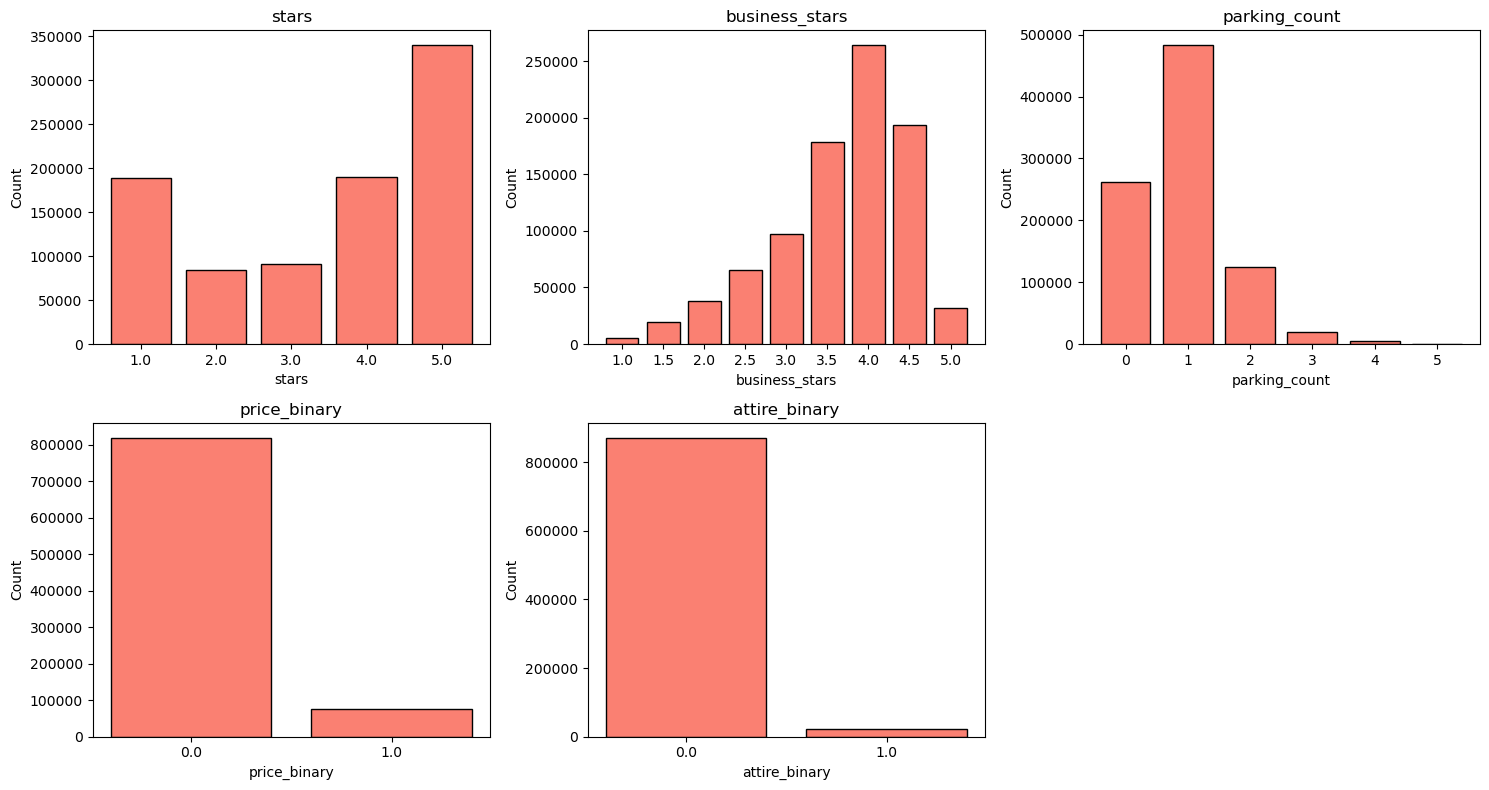

In [6]:
# Categorical Features Bar Charts
cat_cols = ['stars', 'business_stars', 'parking_count', 'price_binary', 'attire_binary']
plot_categorical_bars(X_train, cat_cols)

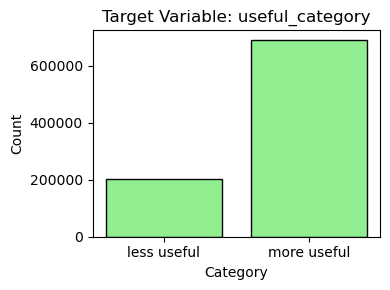

In [7]:
# Target Variable Distribution
plot_target_distribution(y_train, "Target Variable: useful_category")

## 5. Numeric Feature Transformation

- Many features exhibit **skewness** (e.g., `user_total_votes` can be heavily skewed, meaning most users have few votes, but a small percentage have very high counts).
- We apply **log-transform** to highly skewed features to mitigate extreme values and approximate a more normal distribution.
- We also scale the numeric features.
- This step typically helps models like Logistic Regression converge more reliably.

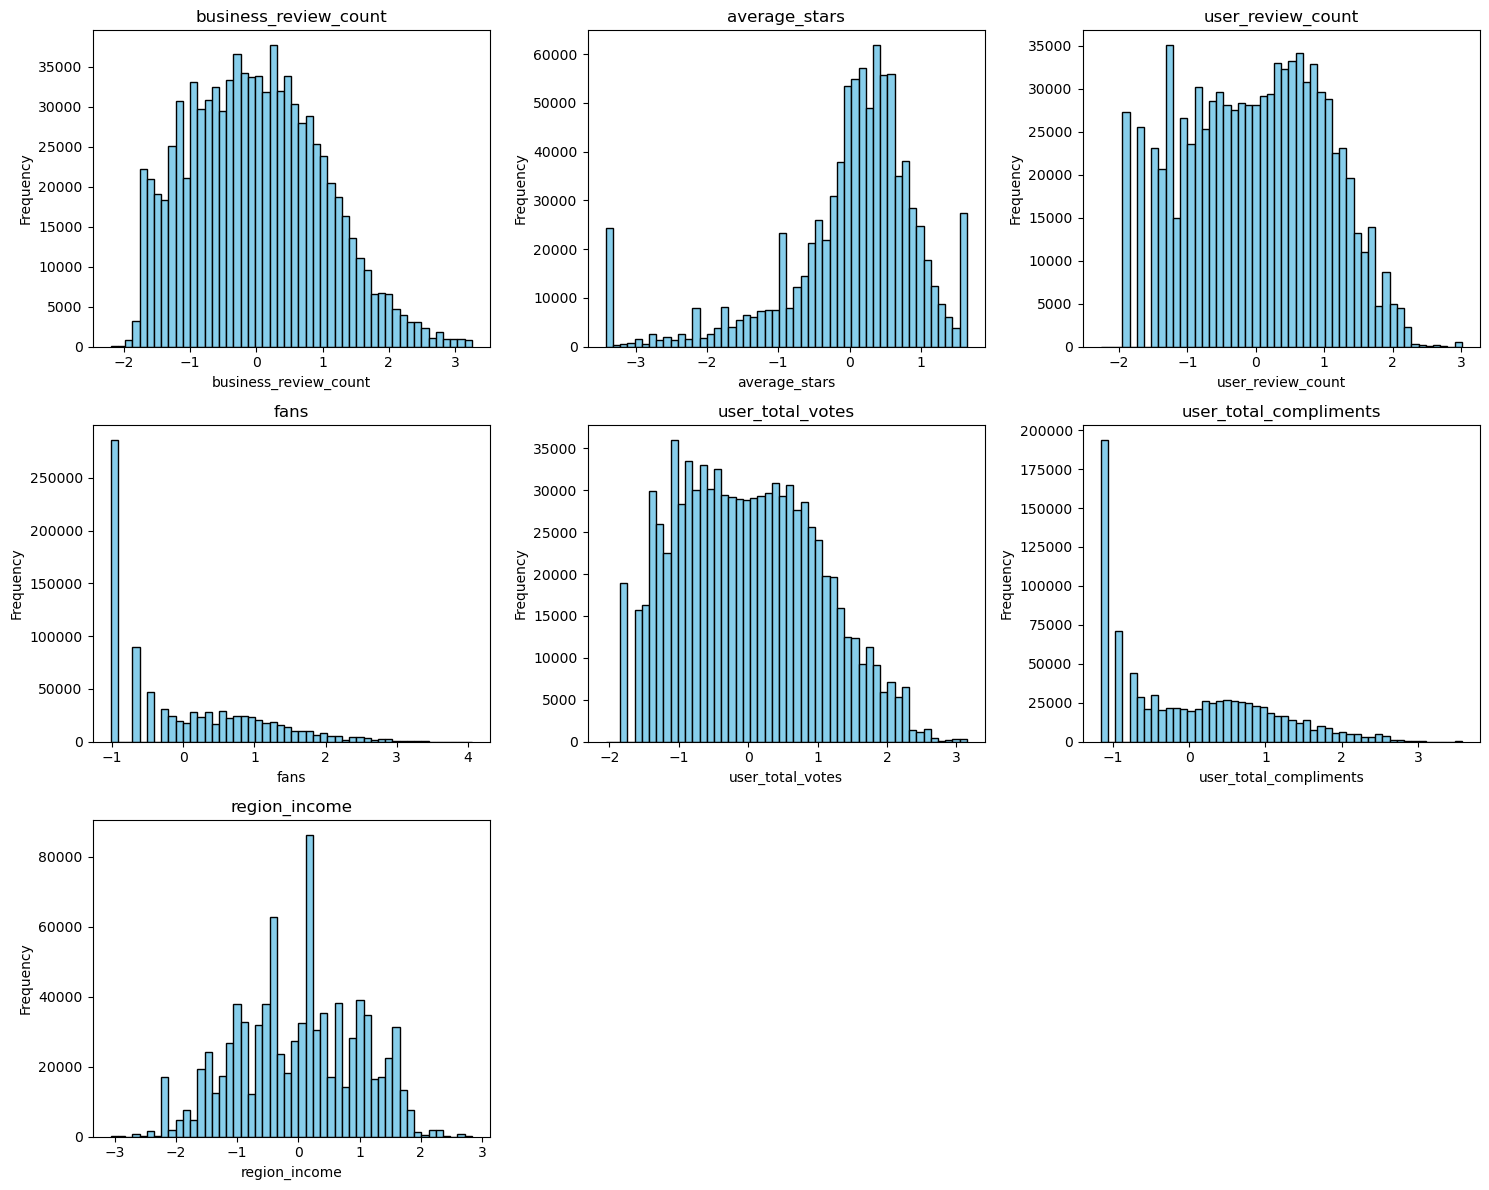

In [8]:
skewed_features = ['business_review_count', 'user_review_count', 'fans', 
                   'user_total_votes', 'user_total_compliments', 'region_income']
numeric_features = ['average_stars', 'business_stars', 'parking_count']
stars_feature = ['stars']

X_train, X_test = transform_numeric_features(X_train, X_test, skewed_features, numeric_features, stars_feature)
plot_numeric_histograms(X_train, num_cols)

## 6. Text Feature Engineering

In TextTransformer, we:
- use sentence-level embeddings (SBERT).
- apply PCA (to reduce dimensionality).
- apply LDA (to capture thematic information).
- use TF-IDF vectorization to capture n-grams.

Balancing performance and dimensionality is key; we may not want thousands of raw n-gram features, so PCA helps keep a manageable size.

In [9]:
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV

# pipeline = Pipeline([
#     ('text_transformer', TextTransformer()),
#     ('classifier', LogisticRegression(max_iter=1000))
# ])

# # Define a grid to test different configurations:
# param_grid = {
#     'text_transformer__use_lda': [True, False],
#     'text_transformer__lda_topics': [5, 10],
#     'text_transformer__vectorizer_type': ['count', 'tfidf'],
#     # Experiment with unigrams vs. unigrams+bigrams
#     'text_transformer__ngram_range': [(1, 1), (1, 2)]
# }

# grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=0)
# grid.fit(X_train, y_train)

# print("Best parameters:", grid.best_params_)
# print("Best cross-validation accuracy:", grid.best_score_)

In [11]:
text_transformer = TextTransformer(
    sbert_model_name='all-MiniLM-L6-v2',
    pca_components=200,
    lda_topics=5,
    vectorizer_type='tfidf',
    tfidf_max_features=500,
    ngram_range=(1, 2),
)
X_train_text, X_test_text = transform_text_features(X_train, X_test, y_train, text_transformer)
print("X_train_transformed shape:", X_train_text.shape)
print("X_test_transformed shape:", X_test_text.shape)

Current PCA components (200) explain only 0.93 variance. Increasing to 220 to reach threshold of 0.95.
X_train_transformed shape: (894245, 738)
X_test_transformed shape: (223562, 738)


To-do: after combining numeric features, textual embeddings, and dimensionality reduction, there are xx columns.

## 7. Preprocessing for Modeling

We create a preprocessor that likely does scaling and one-hot encoding. Then we transform the entire training and test sets using that pipeline.

In [12]:
original_cols = list(X_train_text.columns)
preprocessor = create_preprocessor(X_train_text)
X_train_ready = preprocessor.fit_transform(X_train_text)
X_test_ready = preprocessor.transform(X_test_text)
print("X_train_ready shape:", X_train_ready.shape)
print("X_test_ready shape:", X_test_ready.shape)

X_train_ready shape: (894245, 518)
X_test_ready shape: (223562, 518)


## 8. Classic Machine Learning Models

- We start with Logistic Regression without using text features at all as a baseline.
- Then we measure performance with the custom comprehensive_evaluation function, which:
    * Prints classification metrics (precision, recall, F1, accuracy).
    * Performs cross-validation with the chosen scoring metric.
    * Optionally provides interpretability with LIME or SHAP, showing feature importances or local explanations.

We also use other algorithms like Random Forest to see if the F1 score or recall improves.

### 8.1 Baseline Logistic Regression (Numeric Only Example)

In [13]:
log_reg = LogisticRegression(C=0.0001, penalty='l2', solver='liblinear')
X_train_num = X_train.drop(columns='text', axis=1)
X_test_num = X_test.drop(columns='text', axis=1)
log_reg.fit(X_train_num, y_train)

LogisticRegression(C=0.0001, solver='liblinear')

Plotting learning curve...


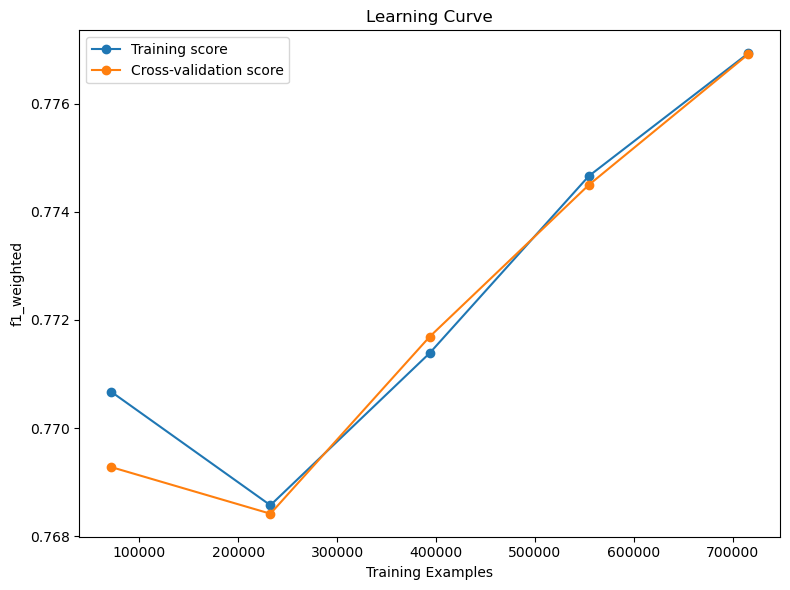


Evaluating on training data:
              precision    recall  f1-score   support

 less useful     0.6652    0.3118    0.4246    204189
 more useful     0.8240    0.9536    0.8841    690056

    accuracy                         0.8070    894245
   macro avg     0.7446    0.6327    0.6543    894245
weighted avg     0.7878    0.8070    0.7792    894245


Evaluating on test data:
              precision    recall  f1-score   support

 less useful     0.6590    0.3109    0.4224     51047
 more useful     0.8237    0.9524    0.8834    172515

    accuracy                         0.8059    223562
   macro avg     0.7413    0.6316    0.6529    223562
weighted avg     0.7861    0.8059    0.7781    223562



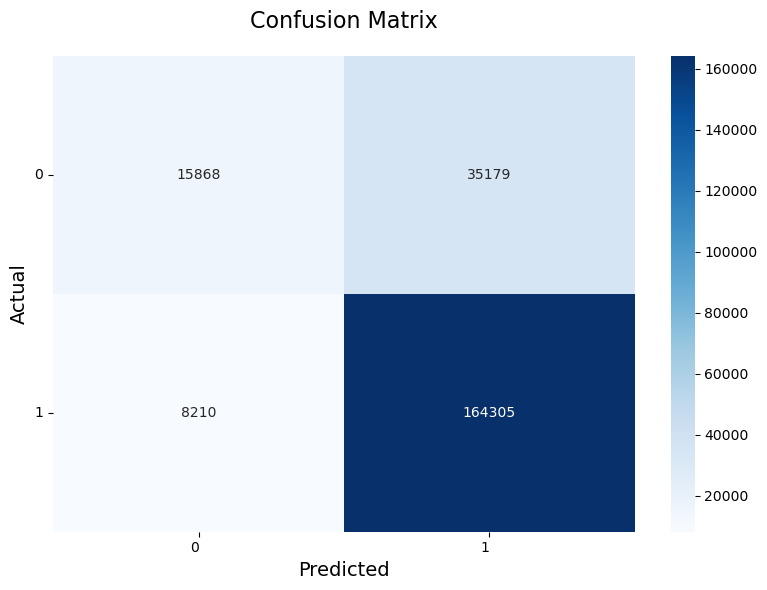

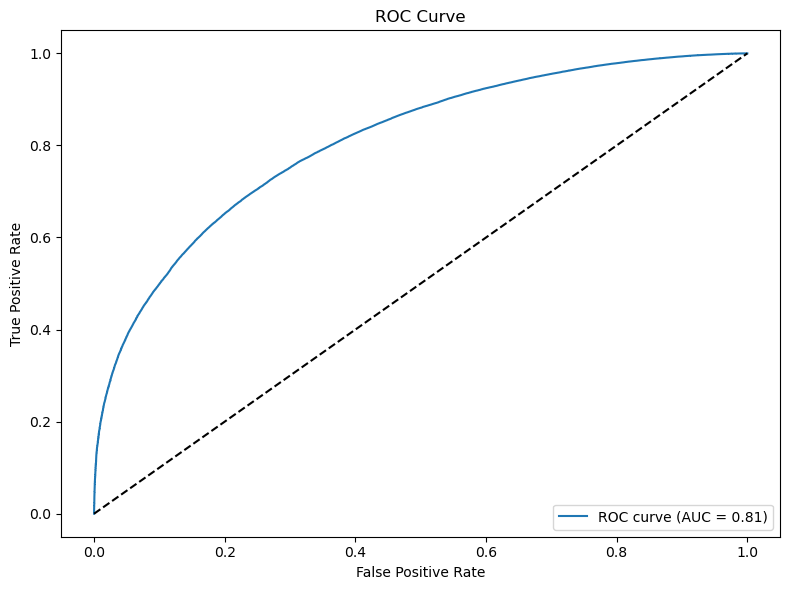

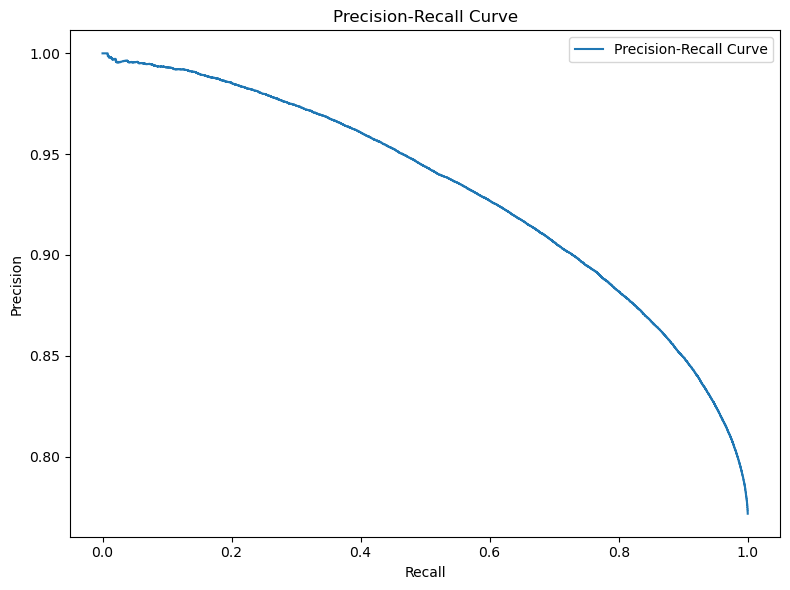

No feature importance attribute found for this model.
LIME Explanations for 10 Test Instances

--------------------------------------------------------------------------------
Instance 0 - Predicted Class: more useful
Original Text:
My boyfriend and I were there for brunch this morning. With quick service, huge portions, and good food, it's one of my new favorite places. I had the shrimp and andouille hash brown creation (which is AMAZING), and he had the breakfast sandwich. Both were absolutely delicious, and we both took leftovers home. They serve pancakes that are bigger than my head--they are absolutely huge! Their prices are very reasonable too.
Plus they're open late and deliver.
Top 10 Features and Their Contribution Scores:
                               Feature  Contribution
      -0.05 < user_total_votes <= 0.74      0.123811
          business_review_count > 0.70      0.111954
     -0.80 < user_review_count <= 0.04      0.043979
                  average_stars > 0.59      0.

In [14]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
comprehensive_evaluation(log_reg, X_train_num, y_train, X_test_num, y_test,
                         model_type='sklearn', feature_names=original_cols, cv=5, scoring="f1_weighted", n_jobs=-1,
                         original_X_train=X_train, original_X_test=X_test)

### 8.2 Logistic Regression with Text + Numeric Features

(TO-do: check)
Usually, including text features substantially improves model performance, because the text provides direct cues about the sentiment and details of the user’s experience.
The LIME explanations show which words or embedding components push the classifier towards predicting “more useful” or “less useful.”

In [15]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C=0.001, penalty='l2', solver='liblinear')
log_reg.fit(X_train_ready, y_train)

LogisticRegression(C=0.001, solver='liblinear')

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
comprehensive_evaluation(log_reg, X_train_ready, y_train, X_test_ready, y_test,
                         model_type='sklearn', feature_names=original_cols, cv=5, scoring="f1_weighted", n_jobs=-1,
                         original_X_train=X_train, original_X_test=X_test)

Plotting learning curve...


### 8.3 Random Forest Model & Tuning

Random Forests often handle high-dimensional data well and can naturally rank feature importances. The pipeline approach with PCA further reduces dimension.
Here, the pipeline uses tuned hyperparameters with a PCA(n_components=100) and a RandomForestClassifier.

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

# Define the best pipeline based on grid search results
best_rf = ImbPipeline([
    ('sampler', 'passthrough'),
    ('pca', PCA(n_components=100)),
    ('clf', RandomForestClassifier(
        n_estimators=80,
        max_depth=10,
        min_samples_split=10,
        class_weight='balanced',
        random_state=42
    ))
])
best_rf.fit(X_train_ready, y_train)

Pipeline(steps=[('sampler', 'passthrough'), ('pca', PCA(n_components=100)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_split=10, n_estimators=80,
                                        random_state=42))])

Plotting learning curve...


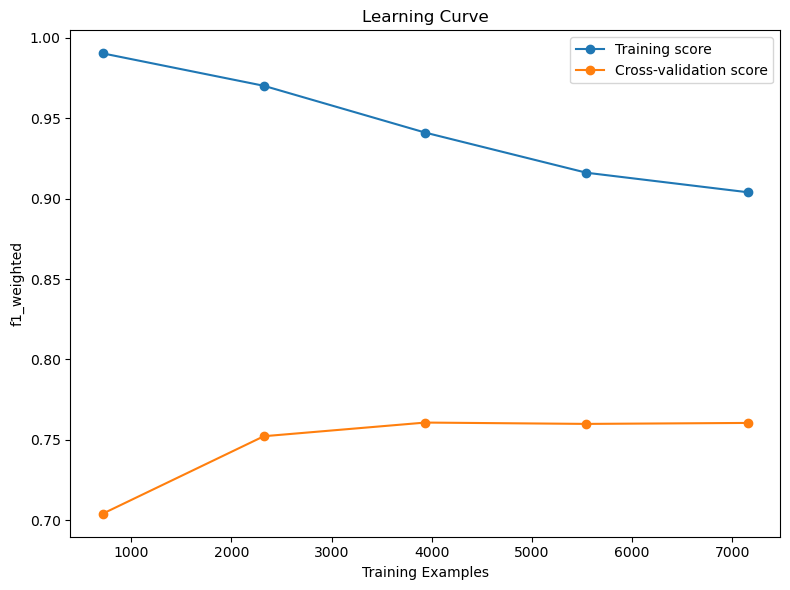


Evaluating on training data:
              precision    recall  f1-score   support

 less useful     0.7292    0.8460    0.7832      2078
 more useful     0.9510    0.9049    0.9274      6864

    accuracy                         0.8912      8942
   macro avg     0.8401    0.8754    0.8553      8942
weighted avg     0.8994    0.8912    0.8939      8942


Evaluating on test data:
              precision    recall  f1-score   support

 less useful     0.4742    0.4769    0.4756       520
 more useful     0.8412    0.8397    0.8405      1716

    accuracy                         0.7554      2236
   macro avg     0.6577    0.6583    0.6580      2236
weighted avg     0.7559    0.7554    0.7556      2236



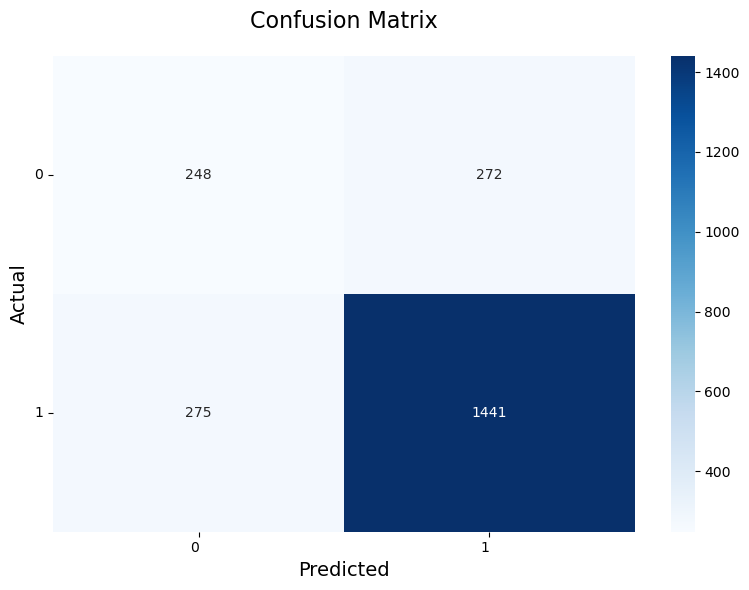

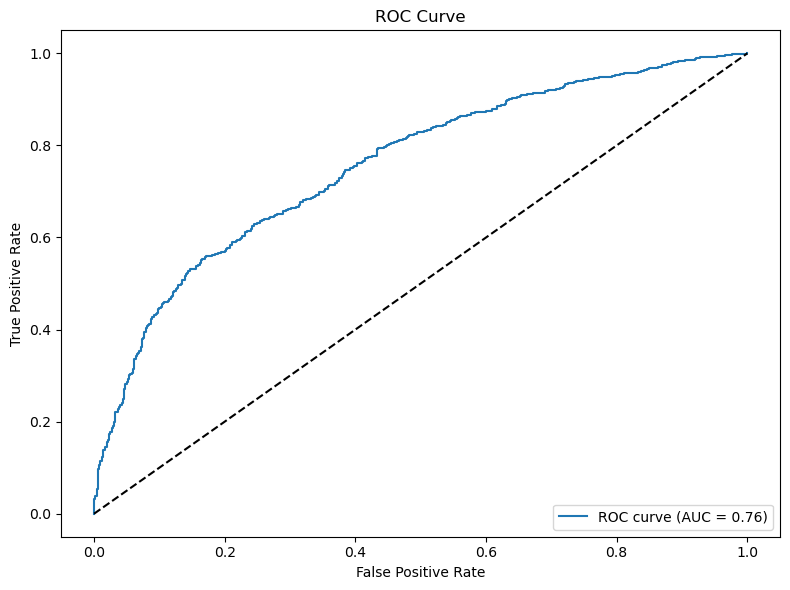

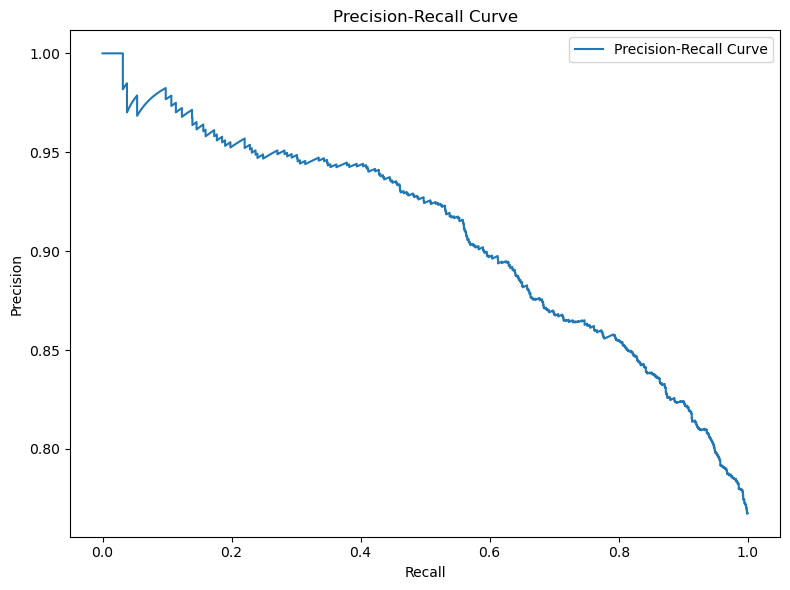

Plotting feature importances from pipeline...


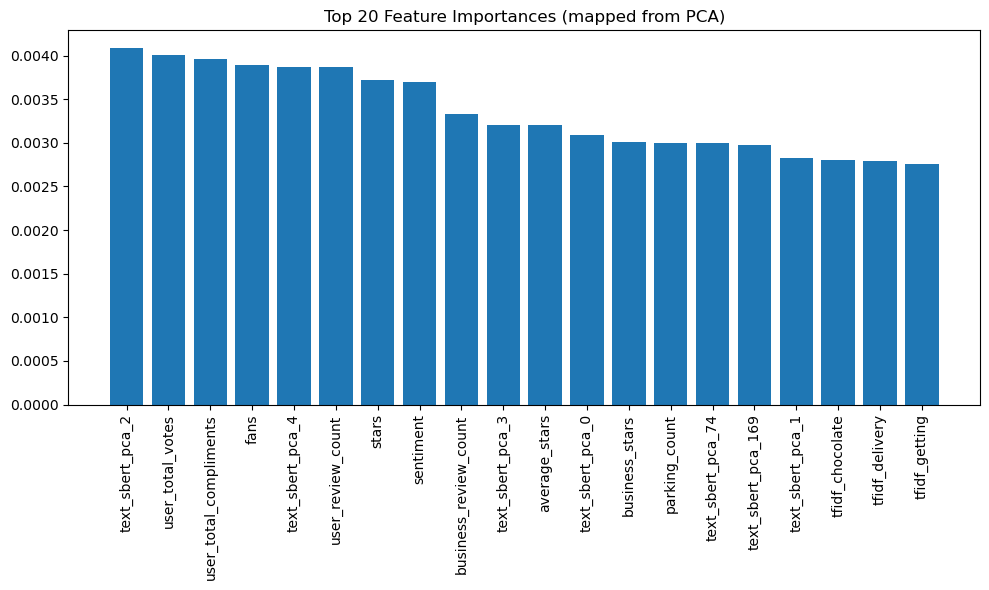

LIME Explanations for 10 Test Instances

--------------------------------------------------------------------------------
Instance 0 - Predicted Class: more useful
Original Text:
This place has a great deal for getting a lot of sushi for a good price. $19.99 for all you can get sushi. There's two choices for this deal. 

1. You can either pay the flat $19.99 fee for 3 rolls, 4 sushi, and 1 appetizer. You don't have to worry about finishing all your food and can take home leftovers. 

2. OR you can order as much sushi as you want for $19.99 but then have to pay for whatever food (and rice) you don't finish. 

The catch with both these deals you have to stick to only the sushi listed on an alternate menu and it excludes some of their specialty rolls, but not all of them.

My boyfriend and I did option 1 each since that already to us was a ton of food and we were really happy with our experience. The sushi was high quality and if you don't mind sharing, we got 6 different rolls to split t

In [ ]:
comprehensive_evaluation(best_rf, X_train_ready, y_train, X_test_ready, y_test,
                         model_type='sklearn', feature_names=original_cols, cv=5, scoring="f1_weighted", n_jobs=-1,
                         original_X_train=X_train, original_X_test=X_test)

## 9. Cost-Sensitive and Ensemble Methods

Because “more useful” reviews may dominate the dataset, plain accuracy can be misleading. We use:
1. **Cost-Sensitive classification** (e.g., `class_weight='balanced'` in RandomForest).
2. **Oversampling** or **synthetic sample generation** (ADASYN, SMOTE) to handle minority classes.
3. **Ensemble** methods like AdaBoost, Stacking, or Bagging to combine the strengths of multiple base learners.
This section explores how shifting the training distribution or weighting classes can affect recall on the minority class (“less useful”).

In [ ]:
clf_cost_sensitive = RandomForestClassifier(
    n_estimators=80,
    max_depth=10,
    min_samples_split=10,
    class_weight='balanced',
    random_state=42
)
clf_cost_sensitive.fit(X_train_ready, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=10, n_estimators=80, random_state=42)

Plotting learning curve...


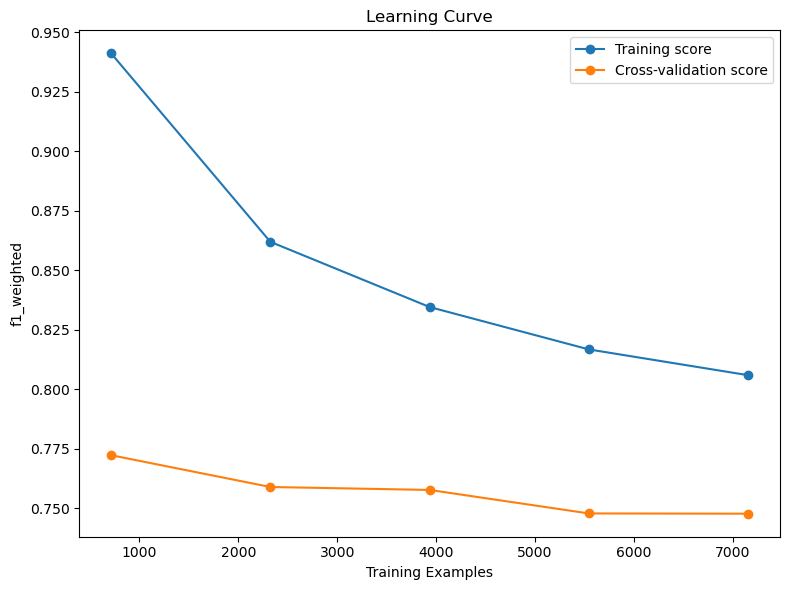


Evaluating on training data:
              precision    recall  f1-score   support

 less useful     0.5176    0.8345    0.6389      2078
 more useful     0.9385    0.7646    0.8426      6864

    accuracy                         0.7808      8942
   macro avg     0.7280    0.7995    0.7408      8942
weighted avg     0.8407    0.7808    0.7953      8942


Evaluating on test data:
              precision    recall  f1-score   support

 less useful     0.4315    0.6846    0.5294       520
 more useful     0.8838    0.7267    0.7976      1716

    accuracy                         0.7169      2236
   macro avg     0.6576    0.7057    0.6635      2236
weighted avg     0.7786    0.7169    0.7352      2236



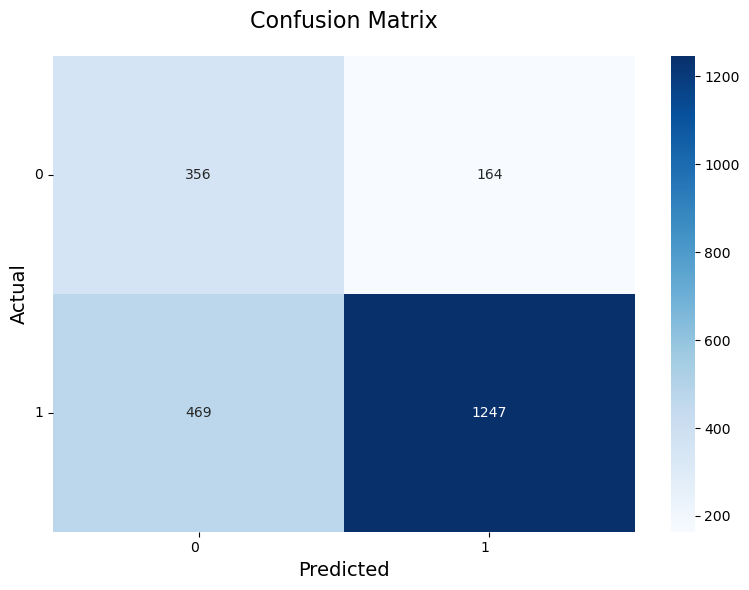

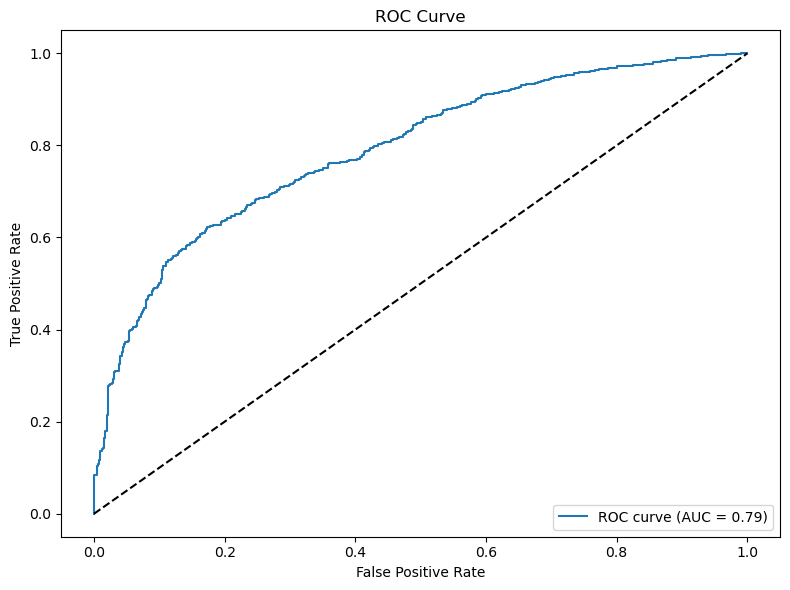

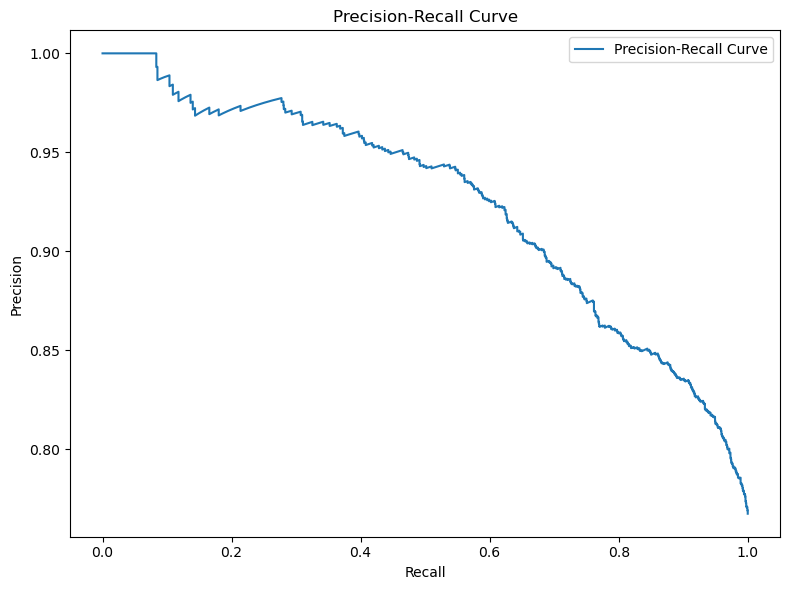

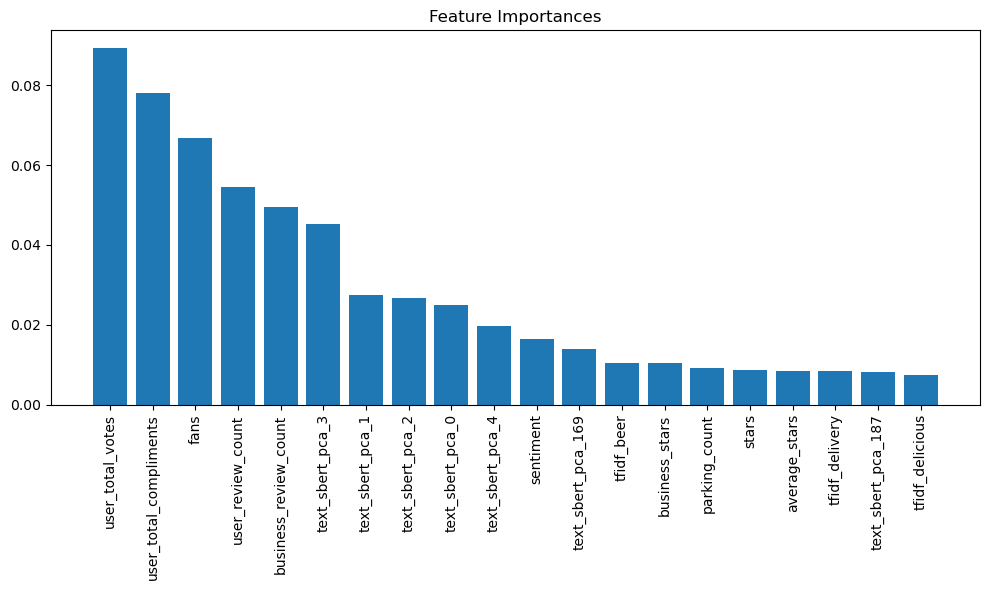

LIME Explanations for 10 Test Instances

--------------------------------------------------------------------------------
Instance 0 - Predicted Class: more useful
Original Text:
This place has a great deal for getting a lot of sushi for a good price. $19.99 for all you can get sushi. There's two choices for this deal. 

1. You can either pay the flat $19.99 fee for 3 rolls, 4 sushi, and 1 appetizer. You don't have to worry about finishing all your food and can take home leftovers. 

2. OR you can order as much sushi as you want for $19.99 but then have to pay for whatever food (and rice) you don't finish. 

The catch with both these deals you have to stick to only the sushi listed on an alternate menu and it excludes some of their specialty rolls, but not all of them.

My boyfriend and I did option 1 each since that already to us was a ton of food and we were really happy with our experience. The sushi was high quality and if you don't mind sharing, we got 6 different rolls to split t

In [ ]:
comprehensive_evaluation(clf_cost_sensitive, X_train_ready, y_train, X_test_ready, y_test,
                         model_type='sklearn', feature_names=original_cols, cv=5, scoring="f1_weighted", n_jobs=-1,
                         original_X_train=X_train, original_X_test=X_test)

In [ ]:
adasyn = ADASYN(random_state=42)
X_train_res, y_train_res = adasyn.fit_resample(X_train_ready, y_train)

clf_adasyn = RandomForestClassifier(
    n_estimators=80,
    max_depth=10,
    min_samples_split=10,
    random_state=42
)
clf_adasyn.fit(X_train_res, y_train_res)

RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=80,
                       random_state=42)

Plotting learning curve...


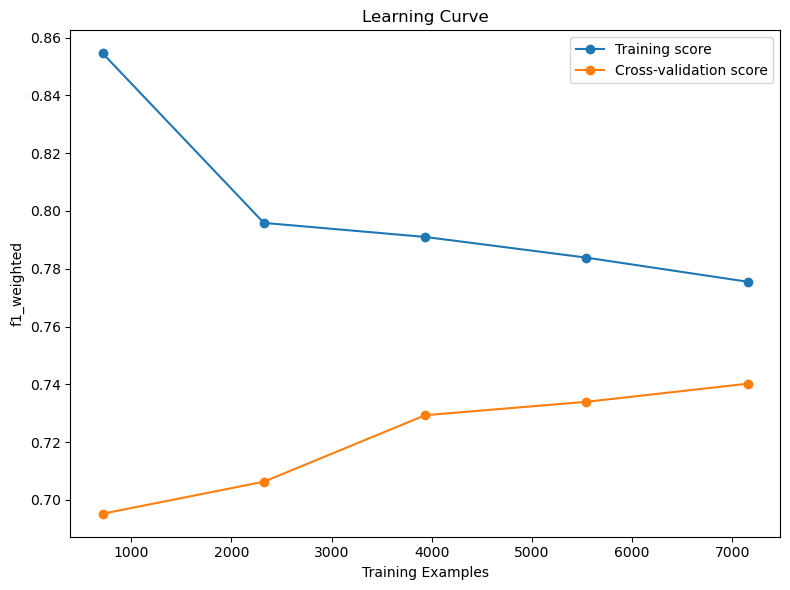


Evaluating on training data:
              precision    recall  f1-score   support

 less useful     0.5559    0.7868    0.6515      2078
 more useful     0.9262    0.8097    0.8640      6864

    accuracy                         0.8044      8942
   macro avg     0.7411    0.7983    0.7578      8942
weighted avg     0.8401    0.8044    0.8147      8942


Evaluating on test data:
              precision    recall  f1-score   support

 less useful     0.4453    0.6577    0.5311       520
 more useful     0.8787    0.7517    0.8103      1716

    accuracy                         0.7299      2236
   macro avg     0.6620    0.7047    0.6707      2236
weighted avg     0.7779    0.7299    0.7454      2236



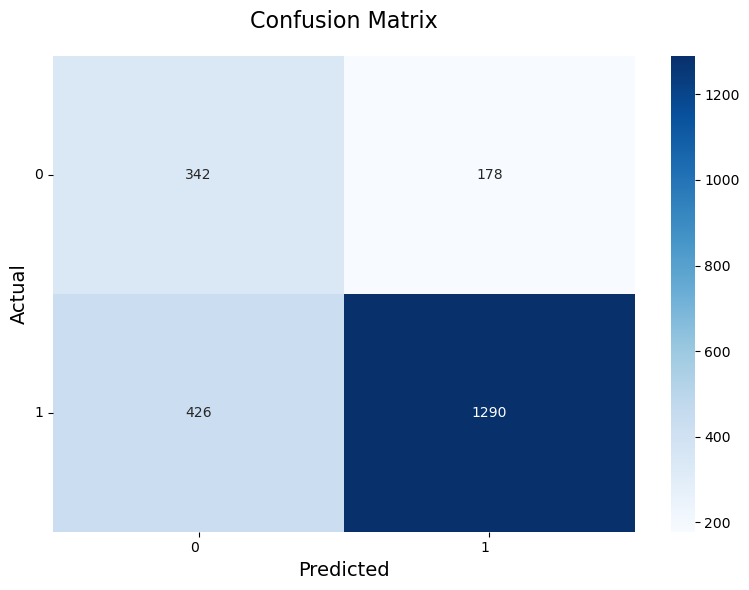

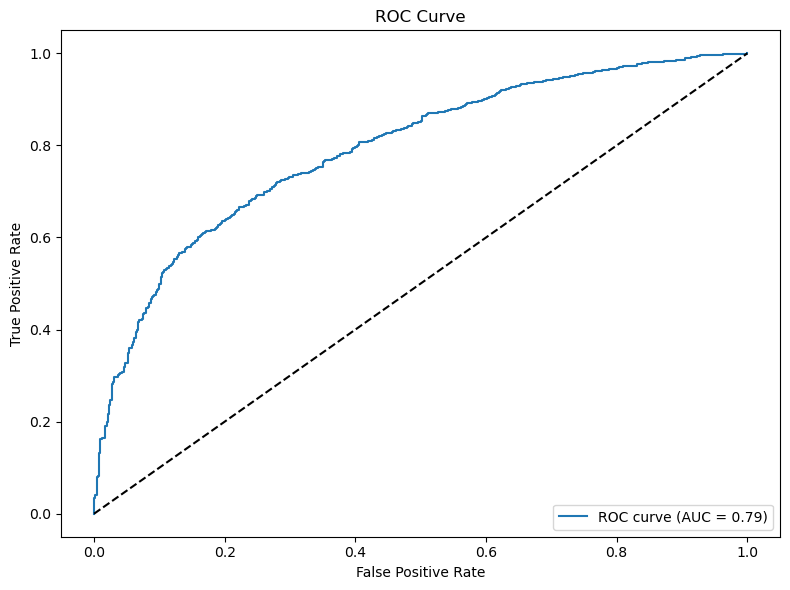

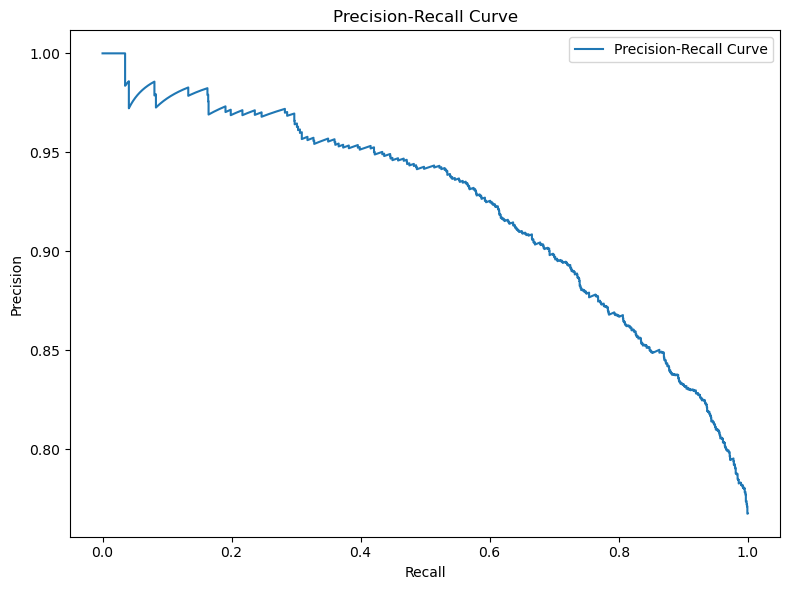

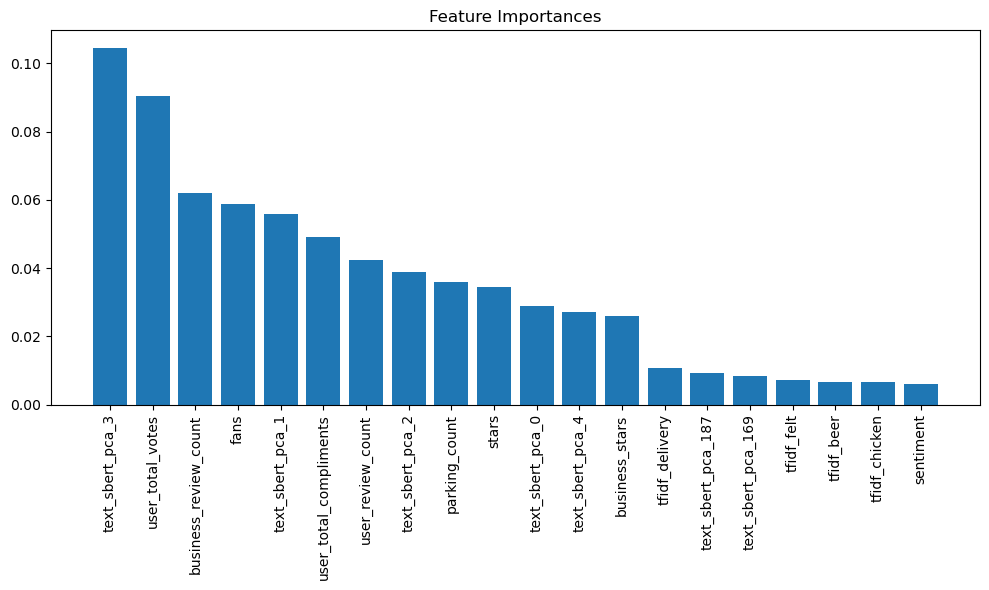

LIME Explanations for 10 Test Instances

--------------------------------------------------------------------------------
Instance 0 - Predicted Class: more useful
Original Text:
This place has a great deal for getting a lot of sushi for a good price. $19.99 for all you can get sushi. There's two choices for this deal. 

1. You can either pay the flat $19.99 fee for 3 rolls, 4 sushi, and 1 appetizer. You don't have to worry about finishing all your food and can take home leftovers. 

2. OR you can order as much sushi as you want for $19.99 but then have to pay for whatever food (and rice) you don't finish. 

The catch with both these deals you have to stick to only the sushi listed on an alternate menu and it excludes some of their specialty rolls, but not all of them.

My boyfriend and I did option 1 each since that already to us was a ton of food and we were really happy with our experience. The sushi was high quality and if you don't mind sharing, we got 6 different rolls to split t

In [ ]:
comprehensive_evaluation(clf_adasyn, X_train_ready, y_train, X_test_ready, y_test,
                         model_type='sklearn', feature_names=original_cols, cv=5, scoring="f1_weighted", n_jobs=-1,
                         original_X_train=X_train, original_X_test=X_test)

In [ ]:
ada_clf = AdaBoostClassifier(n_estimators=50, random_state=42)
ada_clf.fit(X_train_ready, y_train)

AdaBoostClassifier(random_state=42)

Plotting learning curve...


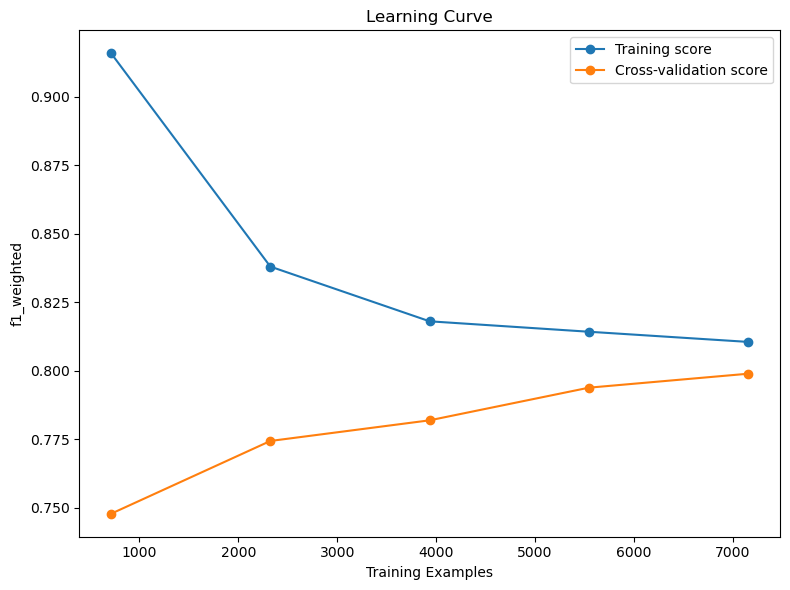


Evaluating on training data:
              precision    recall  f1-score   support

 less useful     0.6841    0.4283    0.5268      2078
 more useful     0.8445    0.9401    0.8898      6864

    accuracy                         0.8212      8942
   macro avg     0.7643    0.6842    0.7083      8942
weighted avg     0.8072    0.8212    0.8054      8942


Evaluating on test data:
              precision    recall  f1-score   support

 less useful     0.6529    0.3942    0.4916       520
 more useful     0.8361    0.9365    0.8835      1716

    accuracy                         0.8104      2236
   macro avg     0.7445    0.6654    0.6875      2236
weighted avg     0.7935    0.8104    0.7923      2236



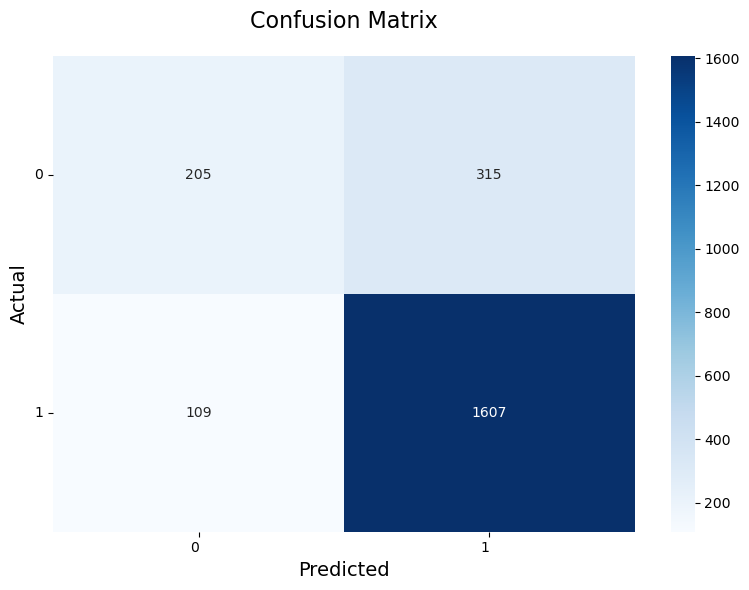

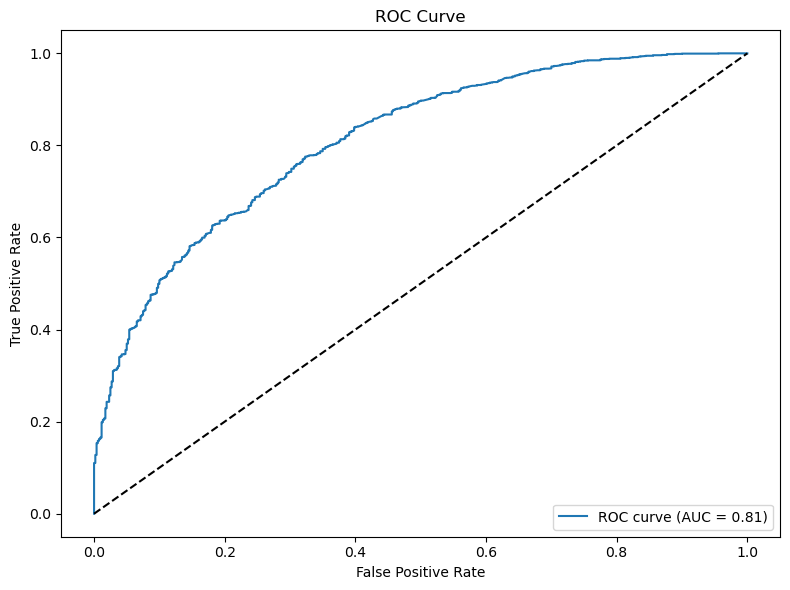

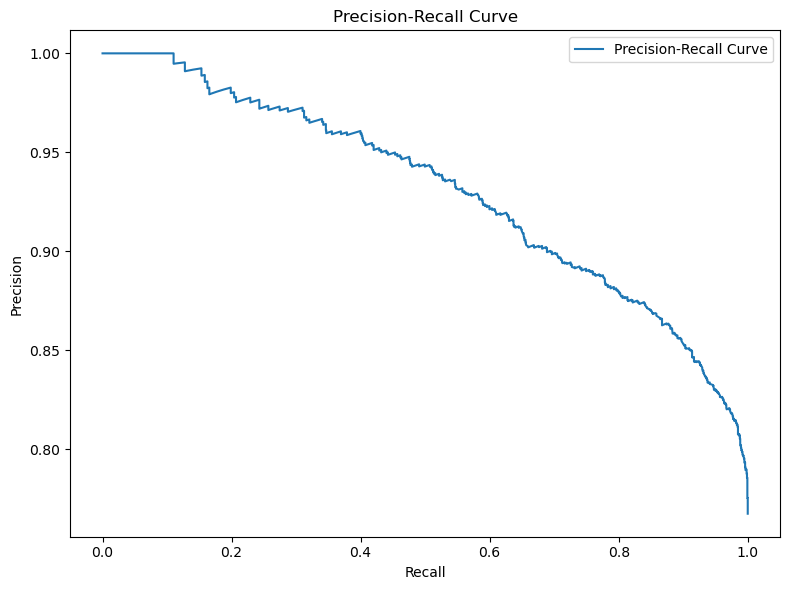

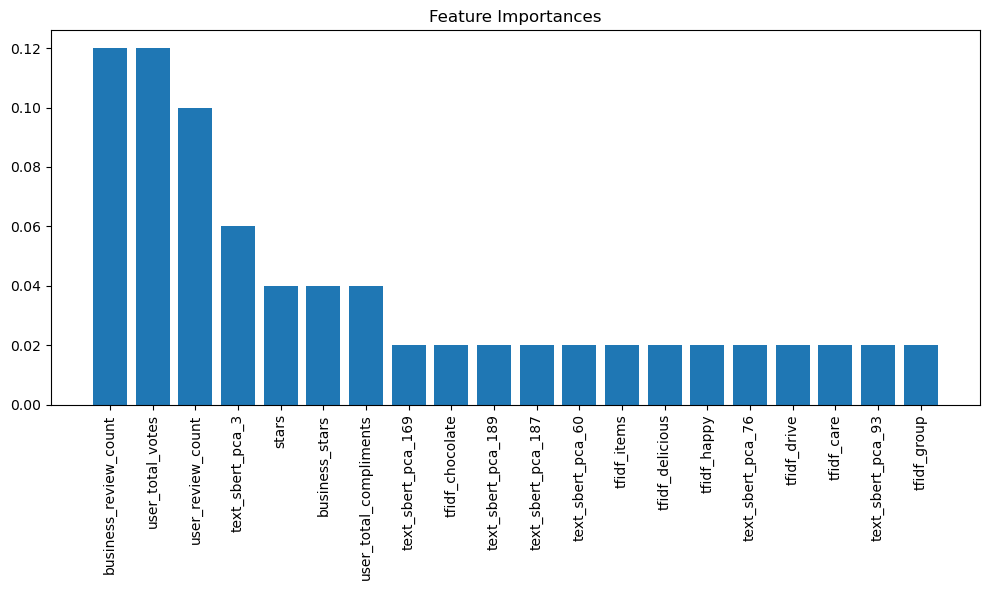

LIME Explanations for 10 Test Instances

--------------------------------------------------------------------------------
Instance 0 - Predicted Class: more useful
Original Text:
This place has a great deal for getting a lot of sushi for a good price. $19.99 for all you can get sushi. There's two choices for this deal. 

1. You can either pay the flat $19.99 fee for 3 rolls, 4 sushi, and 1 appetizer. You don't have to worry about finishing all your food and can take home leftovers. 

2. OR you can order as much sushi as you want for $19.99 but then have to pay for whatever food (and rice) you don't finish. 

The catch with both these deals you have to stick to only the sushi listed on an alternate menu and it excludes some of their specialty rolls, but not all of them.

My boyfriend and I did option 1 each since that already to us was a ton of food and we were really happy with our experience. The sushi was high quality and if you don't mind sharing, we got 6 different rolls to split t

In [ ]:
comprehensive_evaluation(ada_clf, X_train_ready, y_train, X_test_ready, y_test,
                         model_type='sklearn', feature_names=original_cols, cv=5, scoring="f1_weighted", n_jobs=-1,
                         original_X_train=X_train, original_X_test=X_test)

In [ ]:
from xgboost import XGBClassifier

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train model with best hyperparameters
best_xgb = XGBClassifier(n_estimators=100, min_child_weight=2, reg_alpha=0.1666, reg_lambda=50, 
                         subsample=0.60, max_depth=5, learning_rate=0.10, gamma=0.5, colsample_bytree=0.7, 
                         random_state=42, eval_metric='logloss')
best_xgb.fit(X_train_ready, y_train_encoded)

# # Predict and convert back to original labels
# y_pred_xgb_encoded = best_xgb.predict(X_test_ready)
# y_pred_xgb = label_encoder.inverse_transform(y_pred_xgb_encoded)

# # Evaluate on test set
# print("XGBoost Classification Report:\n", 
#       classification_report(y_test, y_pred_xgb, digits=4))

# # Evaluate on training set
# y_train_pred_xgb_encoded = best_xgb.predict(X_train_ready)
# y_train_pred_xgb = label_encoder.inverse_transform(y_train_pred_xgb_encoded)
# print("Train XGBoost Classification Report:\n", 
#       classification_report(y_train, y_train_pred_xgb, digits=4))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Plotting learning curve...


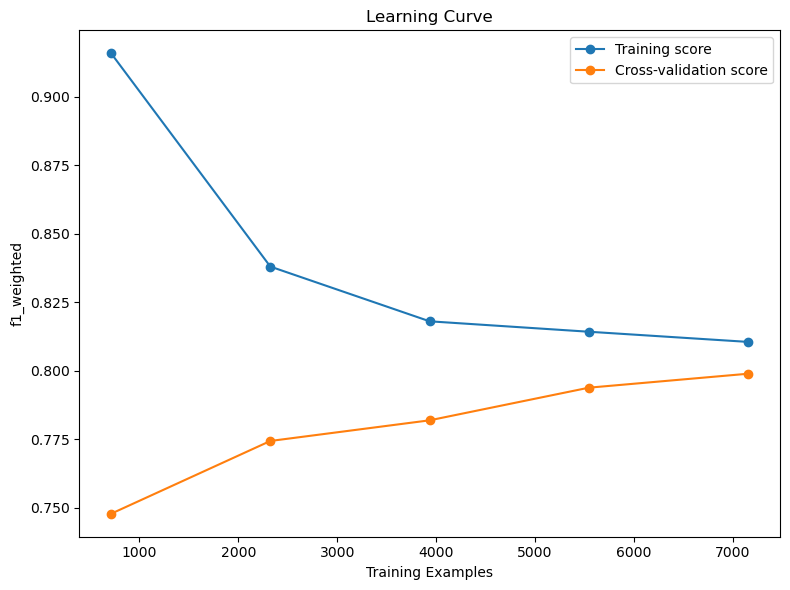


Evaluating on training data:
              precision    recall  f1-score   support

 less useful     0.6841    0.4283    0.5268      2078
 more useful     0.8445    0.9401    0.8898      6864

    accuracy                         0.8212      8942
   macro avg     0.7643    0.6842    0.7083      8942
weighted avg     0.8072    0.8212    0.8054      8942


Evaluating on test data:
              precision    recall  f1-score   support

 less useful     0.6529    0.3942    0.4916       520
 more useful     0.8361    0.9365    0.8835      1716

    accuracy                         0.8104      2236
   macro avg     0.7445    0.6654    0.6875      2236
weighted avg     0.7935    0.8104    0.7923      2236



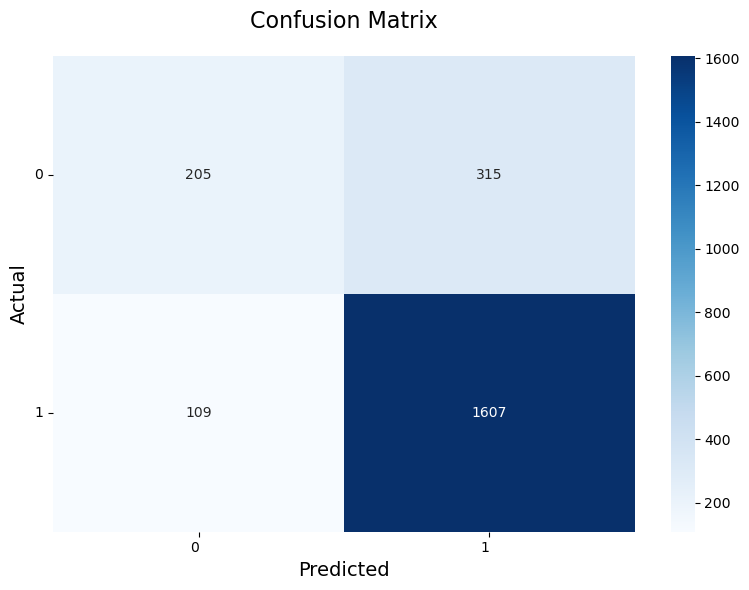

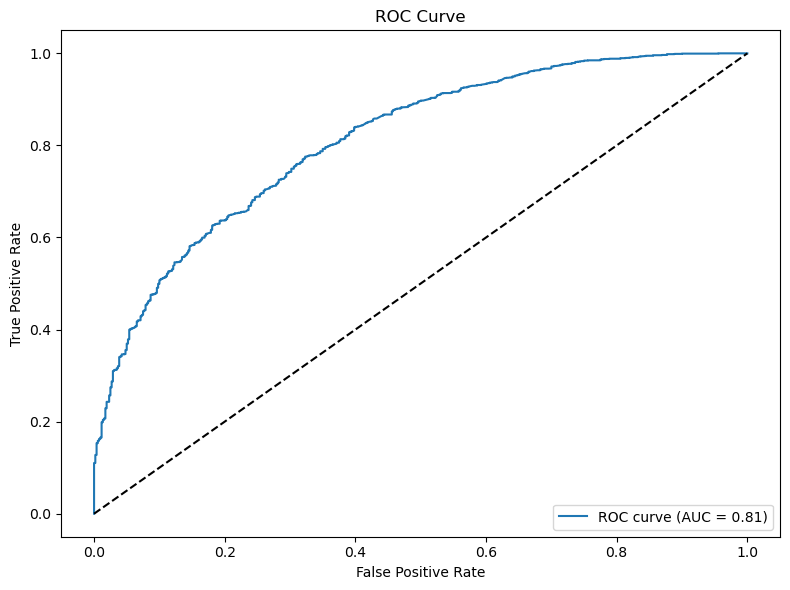

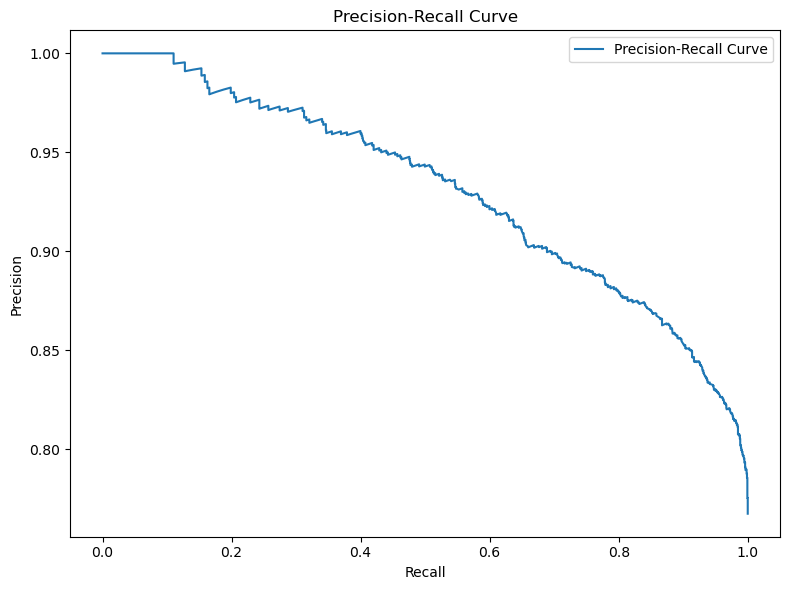

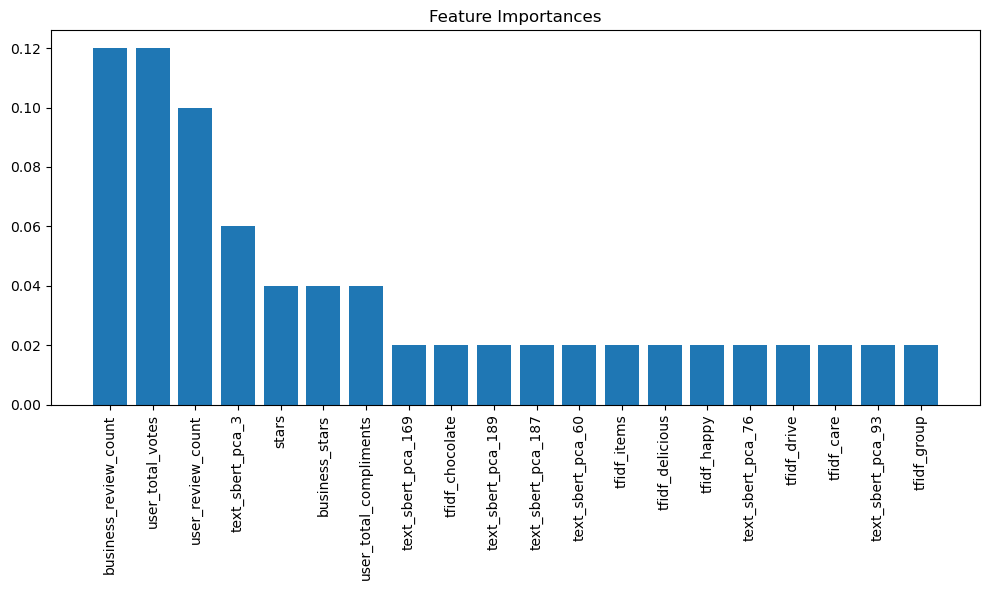

LIME Explanations for 10 Test Instances

--------------------------------------------------------------------------------
Instance 0 - Predicted Class: more useful
Original Text:
This place has a great deal for getting a lot of sushi for a good price. $19.99 for all you can get sushi. There's two choices for this deal. 

1. You can either pay the flat $19.99 fee for 3 rolls, 4 sushi, and 1 appetizer. You don't have to worry about finishing all your food and can take home leftovers. 

2. OR you can order as much sushi as you want for $19.99 but then have to pay for whatever food (and rice) you don't finish. 

The catch with both these deals you have to stick to only the sushi listed on an alternate menu and it excludes some of their specialty rolls, but not all of them.

My boyfriend and I did option 1 each since that already to us was a ton of food and we were really happy with our experience. The sushi was high quality and if you don't mind sharing, we got 6 different rolls to split t

In [ ]:
comprehensive_evaluation(ada_clf, X_train_ready, y_train, X_test_ready, y_test,
                         model_type='sklearn', feature_names=original_cols, cv=5, scoring="f1_weighted", n_jobs=-1,
                         original_X_train=X_train, original_X_test=X_test)

In [ ]:
base_estimator = DecisionTreeClassifier(max_depth=10, random_state=42)
estimators, estimator_weights = adacost_train(X_train_ready, y_train, base_estimator, n_estimators=50, cost_factor=2.0)
y_pred_adacost = adacost_predict(X_test_ready, estimators, estimator_weights)
print("AdaCost-Modified AdaBoost Classification Report:")
print(classification_report(y_test, y_pred_adacost, digits=4))

AdaCost-Modified AdaBoost Classification Report:
              precision    recall  f1-score   support

 less useful     0.3742    0.8519    0.5200       520
 more useful     0.9268    0.5682    0.7045      1716

    accuracy                         0.6342      2236
   macro avg     0.6505    0.7101    0.6122      2236
weighted avg     0.7983    0.6342    0.6616      2236



In [ ]:
estimators_stack = [
    ('lr', LogisticRegression(class_weight='balanced', max_iter=1000)),
    ('rf', RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42)),
    ('ada', AdaBoostClassifier(n_estimators=50, random_state=42))
]
meta_clf = LogisticRegression()
stacking_model = StackingClassifier(estimators=estimators_stack, final_estimator=meta_clf, cv=5)
stacking_model.fit(X_train_ready, y_train)
y_pred_stack = stacking_model.predict(X_test_ready)
print("Stacking Ensemble Classification Report:")
print(classification_report(y_test, y_pred_stack, digits=4))

Stacking Ensemble Classification Report:
              precision    recall  f1-score   support

 less useful     0.6503    0.4327    0.5196       520
 more useful     0.8439    0.9295    0.8846      1716

    accuracy                         0.8140      2236
   macro avg     0.7471    0.6811    0.7021      2236
weighted avg     0.7989    0.8140    0.7998      2236



## 10. Deep Learning Experiments

The following sections demonstrate deep learning experiments. We tried:
- **Fine-tuned BERT** on the review text.
- **LSTM** networks for sequential text modeling.
- **Multi-Input** architectures that combine numeric and text embedding branches.

### 10.1 BERT Fine-Tuning

Prepare datasets and fine-tune a BERT model using our utility function.

In [ ]:
# Prepare train and test datasets for BERT fine-tuning
from datasets import Dataset, DatasetDict

train_df = pd.concat([X_train[['text']].reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
test_df = pd.concat([X_test[['text']].reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
label_mapping = {"less useful": 0, "more useful": 1}
train_df['label'] = train_df['useful_category'].map(label_mapping)
test_df['label'] = test_df['useful_category'].map(label_mapping)

train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])
hf_dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

def tokenize_function(examples):
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

tokenized_datasets = hf_dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")

# Fine-tune BERT using the utility function from deep_learning.py
trainer = finetune_bert(
    train_dataset=tokenized_datasets["train"],
    test_dataset=tokenized_datasets["test"],
    model_path="google-bert/bert-base-uncased",
    output_dir="./bert_finetune_results"
)

Map:   0%|          | 0/8942 [00:00<?, ? examples/s]

Map:   0%|          | 0/2236 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/Users/apple/Desktop/Math-148-Project/utils/deep_learning.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss


Process LokyProcess-8:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py", line 415, in _process_worker
    is_clean = worker_exit_lock.acquire(True, timeout=30)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
# Evaluate the fine-tuned BERT model
predictions_output = trainer.predict(tokenized_datasets["test"])
pred_labels = np.argmax(predictions_output.predictions, axis=1)
print("BERT Fine-Tuning Classification Report:")
print(classification_report(predictions_output.label_ids, pred_labels, target_names=["less useful", "more useful"], digits=4))

BERT Fine-Tuning Classification Report:
              precision    recall  f1-score   support

 less useful     0.6000    0.1837    0.2812        49
 more useful     0.8086    0.9657    0.8802       175

    accuracy                         0.7946       224
   macro avg     0.7043    0.5747    0.5807       224
weighted avg     0.7630    0.7946    0.7492       224



### 10.2 Keras LSTM Model

Train a Keras LSTM model for text classification using the utility function.

In [ ]:
texts = df['text'].astype(str).tolist()
labels = df['useful_category'].tolist()

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(
    texts, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 10000
tokenizer_keras = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer_keras.fit_on_texts(X_text_train)
X_train_seq = tokenizer_keras.texts_to_sequences(X_text_train)
X_test_seq = tokenizer_keras.texts_to_sequences(X_text_test)

max_length = 200
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# Build and train the LSTM model using the utility function from deep_learning.py
lstm_model = build_lstm_model(max_words=max_words, max_length=max_length, embedding_dim=64)
lstm_model.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
lstm_history = lstm_model.fit(
    X_train_pad, y_text_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

224/224 ━━━━━━━━━━━━━━━━━━━━ 17s 76ms/step - accuracy: 0.7708 - loss: 0.5289 - val_accuracy: 0.7658 - val_loss: 0.5260
Restoring model weights from the end of the best epoch: 1.


In [ ]:
lstm_y_train_pred_probs = lstm_model.predict(X_train_pad)
lstm_y_train_pred = (lstm_y_train_pred_probs > 0.5).astype(int).flatten()
y_true = y_text_train.flatten()
print(classification_report(y_true, lstm_y_train_pred, digits=4))

280/280 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      2078
           1     0.7676    1.0000    0.8685      6864

    accuracy                         0.7676      8942
   macro avg     0.3838    0.5000    0.4343      8942
weighted avg     0.5892    0.7676    0.6667      8942



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
comprehensive_evaluation(lstm_model, X_train_pad, y_text_train, X_test_pad, y_text_test, model_type='keras', original_X_test=X_test)


Evaluating deep learning model on test set...
Test evaluation results: [0.5348819494247437, 0.7674418687820435]
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

Classification Report (Test):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       520
           1     0.7674    1.0000    0.8684      1716

    accuracy                         0.7674      2236
   macro avg     0.3837    0.5000    0.4342      2236
weighted avg     0.5890    0.7674    0.6665      2236



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 10.3 Multi-Input Model (Text + Other Features)

This model combines text features (processed via an embedding and LSTM) with additional numeric features.

In [ ]:
# Prepare text data (reuse tokenizer)
text_train = X_train['text'].astype(str).tolist()
text_test = X_test['text'].astype(str).tolist()

tokenizer_keras.fit_on_texts(text_train)
X_train_seq = tokenizer_keras.texts_to_sequences(text_train)
X_test_seq = tokenizer_keras.texts_to_sequences(text_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

In [ ]:
# Prepare additional features: drop the text column and one-hot encode categoricals
X_train_other = X_train.drop(columns=['text']).copy()
X_test_other = X_test.drop(columns=['text']).copy()
X_train_other = pd.get_dummies(X_train_other, drop_first=True)
X_test_other = pd.get_dummies(X_test_other, drop_first=True)
X_train_other, X_test_other = X_train_other.align(X_test_other, join='inner', axis=1)

In [ ]:
scaler = StandardScaler()
X_train_other_scaled = scaler.fit_transform(X_train_other)
X_test_other_scaled = scaler.transform(X_test_other)

In [ ]:
# Encode target variable
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

In [ ]:
# Build and train the multi-input model using the utility function
num_other_features = X_train_other_scaled.shape[1]
multi_input_model = build_multi_input_model(max_length=max_length, max_words=max_words, num_other_features=num_other_features, embedding_dim=64)
multi_input_model.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 200, 64)   │    640,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     33,024 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ other_input         │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │        416 │ other_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,080 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 677,633 (2.58 MB)

 Trainable params: 677,633 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
history = multi_input_model.fit(
    {'text_input': X_train_pad, 'other_input': X_train_other_scaled},
    y_train_enc,
    epochs=1,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

224/224 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - accuracy: 0.8420 - loss: 0.3383 - val_accuracy: 0.7848 - val_loss: 0.5054
Restoring model weights from the end of the best epoch: 1.


In [ ]:
mi_y_train_pred_probs = multi_input_model.predict({'text_input': X_train_pad, 'other_input': X_train_other_scaled})
mi_y_train_pred = (mi_y_train_pred_probs > 0.5).astype(int).flatten()
y_true = y_text_train.flatten()
print(classification_report(y_true, mi_y_train_pred, digits=4))

280/280 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
              precision    recall  f1-score   support

           0     0.6589    0.5818    0.6179      2078
           1     0.8777    0.9088    0.8930      6864

    accuracy                         0.8328      8942
   macro avg     0.7683    0.7453    0.7555      8942
weighted avg     0.8269    0.8328    0.8291      8942




Evaluating deep learning model on test set...
Test evaluation results: [0.5156786441802979, 0.7853309512138367]
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

Classification Report (Test):
              precision    recall  f1-score   support

           0     0.5413    0.5038    0.5219       520
           1     0.8527    0.8706    0.8616      1716

    accuracy                         0.7853      2236
   macro avg     0.6970    0.6872    0.6918      2236
weighted avg     0.7803    0.7853    0.7826      2236



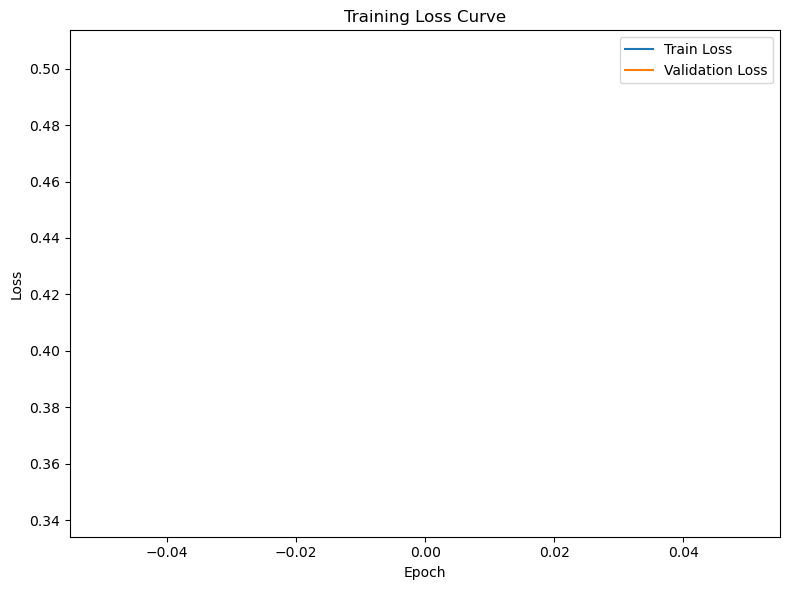

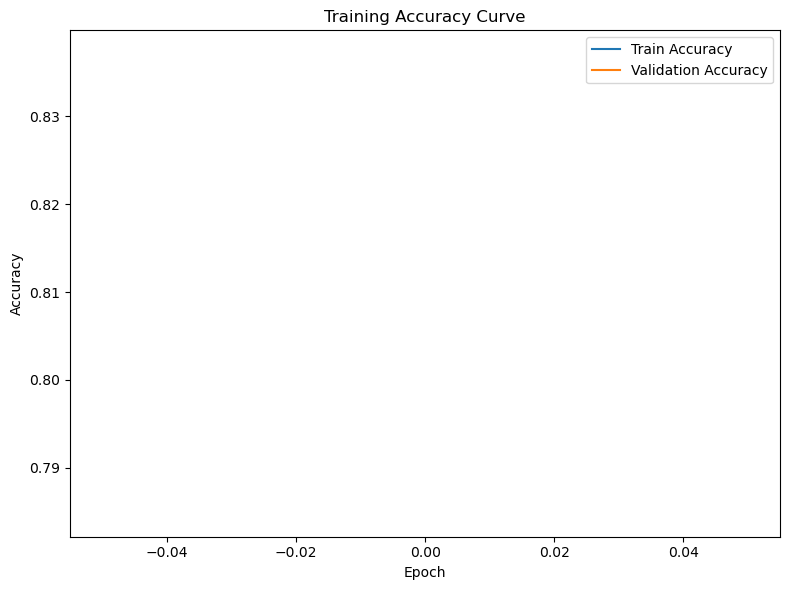

In [ ]:
comprehensive_evaluation(multi_input_model, {'text_input': X_train_pad, 'other_input': X_train_other_scaled}, y_text_train, {'text_input': X_test_pad, 'other_input': X_test_other_scaled}, y_text_test, model_type='keras', original_X_test=X_test, history=history)